In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cpu para entrenar


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.9 * len(full_train_dataset)) # 90% para entrenamiento
valid_size = len(full_train_dataset) - train_size # 10% para validación
train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Ejercicio 1
Supresor de ruido de imágenes con el MNIST con autoencoder lineal y convolucional

In [4]:
def reduce_resolution(images, scale_factor=2):
    transformed_images = nn.functional.interpolate(images, scale_factor=1/scale_factor, mode='bicubic')
    return transformed_images

def test_and_print(images, model, resolution_change=False):
    # Denoise test images and plot results
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            original_images, _ = data
            if resolution_change:
                # Convert images to the desired resolution
                resized_images = reduce_resolution(original_images, scale_factor=2)
                noisy_images = resized_images
            else:
                noisy_images = add_noise(original_images)
            
            denoised_images = model(noisy_images)
            break  # Just denoise one batch for visualization
    
    plt.figure(figsize=(20, 4))
    for i in range(10):
        # Original images
        plt.subplot(3, 10, i + 1)
        plt.imshow(original_images[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    
        # Noisy or Resized images based on condition
        plt.subplot(3, 10, i + 11)
        if resolution_change:
            padded_image = np.ones((28, 28))  # Initialize with white pixels
            # Place the 14x14 image at the center of the canvas
            padded_image[7:21, 7:21] = resized_images[i].numpy().reshape(14, 14)
            plt.imshow(padded_image, cmap='gray')
            plt.axis('off')
        else:
            plt.imshow(noisy_images[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    
        # Denoised images
        plt.subplot(3, 10, i + 21)
        plt.imshow(denoised_images[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Epoch [1/10] Train Loss: 0.2658
Epoch [2/10] Train Loss: 0.2029
Epoch [3/10] Train Loss: 0.1887
Epoch [4/10] Train Loss: 0.1825
Epoch [5/10] Train Loss: 0.1789
Epoch [6/10] Train Loss: 0.1764
Epoch [7/10] Train Loss: 0.1743
Epoch [8/10] Train Loss: 0.1725
Epoch [9/10] Train Loss: 0.1711
Epoch [10/10] Train Loss: 0.1698


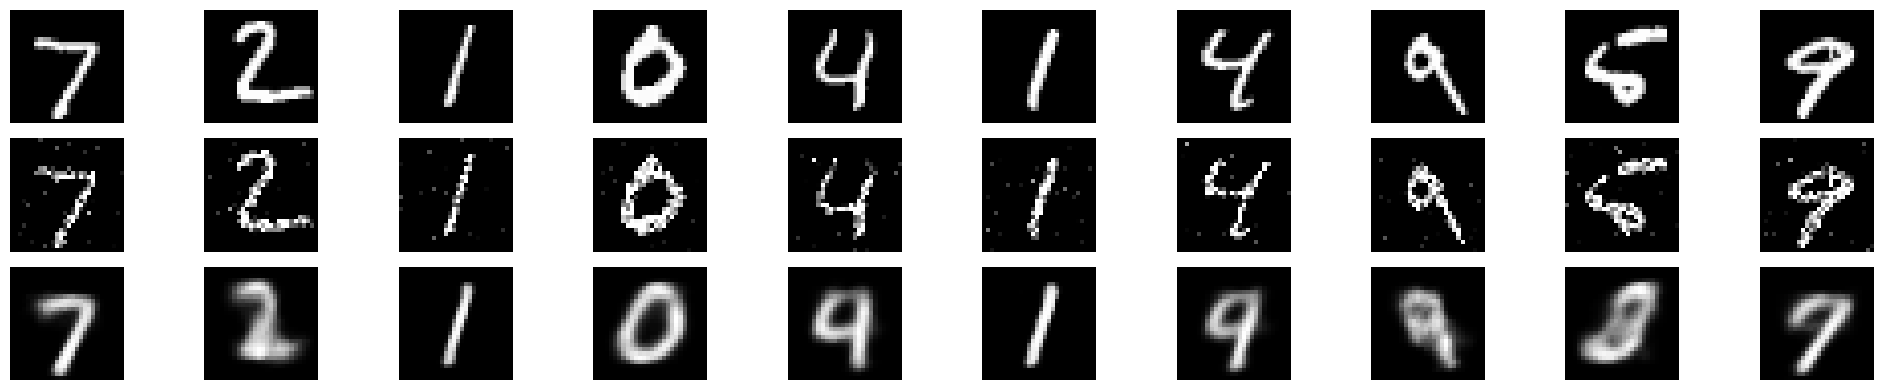

In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#noise addition function
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

#normalization checking
def check_normalize(tensor):
    if tensor.min() < 0 or tensor.max() > 1:
        tensor_normalized = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    return tensor_normalized

#####################################

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Autoencoder, self).__init__()
        input_size = input_shape[0] * input_shape[1] * input_shape[2]
        output_size = output_shape[0] * output_shape[1] * output_shape[2]

        self.encoder = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,output_size),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        #decoded = decoded.view(decoded.size(0), 1, 28, 28)  # Reshape to desired output shape
        return decoded
        
model = Autoencoder((1,28,28),(1,28,28))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.reshape(-1,28*28)
        noisy_images = add_noise(images)  # Add noise to the images
        optimizer.zero_grad()
        outputs = model(noisy_images)
        normimg = check_normalize(images)
        loss = criterion(outputs, normimg)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}")


test_and_print(images,model,False)



In [7]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA

In [10]:
# PSNR (Peak Signal-to-Noise Ratio)
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA

def PSNR(model,valid_loader):
    model.eval()
    
    psnr_values = []
    
    for val_data in valid_loader:
        inputs = val_data[0].to(device)
        noisy_inputs = add_noise(inputs)
    
        with torch.no_grad():
            outputs = model(noisy_inputs)
    
        inputs = inputs.cpu().numpy()
        outputs = outputs.cpu().numpy()
    
        mse = mean_squared_error(inputs.flatten(), outputs.flatten())
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    
        psnr_values.append(psnr)
    
    average_psnr = np.mean(psnr_values)
    return average_psnr

print(f"PSNR promedio: {PSNR(model,valid_loader):.2f} dB")

NameError: name 'add_noise' is not defined

In [20]:
# MAE (Mean Absolute Error)
def MAE(model,valid_loader):
    mae_scores = []
    
    with torch.no_grad():
        for batch_data in valid_loader:
            inputs = batch_data[0].to(device)
            noisy_inputs = add_noise(inputs)
    
            reconstructed_outputs = model(noisy_inputs)
            mae = F.l1_loss(reconstructed_outputs.view(reconstructed_outputs.size(0), 1, 28, 28), inputs, reduction='mean').item()
            mae_scores.append(mae)
    
    average_mae = sum(mae_scores) / len(mae_scores)
    return(average_mae)
    
print(f"MAE promedio: {MAE(model,valid_loader):.4f}")

MAE promedio: 0.9362


In [21]:
class Autoencoder_Convolutional(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

        self.output_shape = output_shape

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # Resize decoded to match the output shape
        decoded = F.interpolate(decoded, size=self.output_shape[1:], mode='bilinear', align_corners=False)

        return decoded
        
model = Autoencoder_Convolutional((1,28,28),(1,28,28))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        noisy_images = add_noise(images)  # Add noise to the images
        optimizer.zero_grad()
        outputs = model(noisy_images)
        normimg = check_normalize(images)
        loss = criterion(outputs, normimg)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}")


test_and_print(images,model,False)


Epoch [1/10] Train Loss: 0.1102
Epoch [2/10] Train Loss: 0.0757
Epoch [3/10] Train Loss: 0.0748
Epoch [4/10] Train Loss: 0.0743
Epoch [5/10] Train Loss: 0.0741
Epoch [6/10] Train Loss: 0.0739


KeyboardInterrupt: 

In [ ]:
print(f"PSNR promedio: {PSNR(model,inputs):.2f} dB")
print(f"MAE promedio: {MAE(model,inputs):.4f}")

# Ejercicio 2
Super resolución de imágenes con el MNIST con autoencoder lineal y convolucional

In [7]:
######################SUPER RESOLUTION WITH LINEAR AUTOENCODER
def reduce_resolution(images, scale_factor=2):
    transformed_images = nn.functional.interpolate(images, scale_factor=1/scale_factor, mode='bicubic')
    return transformed_images

#normalization checking
def check_normalize(tensor):
    if tensor.min() < 0 or tensor.max() > 1:
        tensor_normalized = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    return tensor_normalized

class Autoencoder(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Autoencoder, self).__init__()
        input_size = input_shape[0] * input_shape[1] * input_shape[2]
        output_size = output_shape[0] * output_shape[1] * output_shape[2]

        self.encoder = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,output_size),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        #decoded = decoded.view(decoded.size(0), 1, 28, 28)  # Reshape to desired output shape
        return decoded
        
model = Autoencoder((1,14,14),(1,28,28))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        #images = images.reshape(-1,28*28)
        reduced_resolution_images = reduce_resolution(images, scale_factor=2)  # Add noise to the images
        optimizer.zero_grad()
        outputs = model(reduced_resolution_images)
        outputs = outputs.view(outputs.size(0), 1, 28, 28)  # Reshape to desired output shape
        normimg = check_normalize(images)
        loss = criterion(outputs, normimg)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}")

test_and_print(images, model, resolution_change=True)


Epoch [1/10] Train Loss: 0.0649
Epoch [2/10] Train Loss: 0.0465
Epoch [3/10] Train Loss: 0.0421
Epoch [4/10] Train Loss: 0.0399
Epoch [5/10] Train Loss: 0.0385
Epoch [6/10] Train Loss: 0.0375
Epoch [7/10] Train Loss: 0.0368
Epoch [8/10] Train Loss: 0.0363
Epoch [9/10] Train Loss: 0.0359
Epoch [10/10] Train Loss: 0.0355


NameError: name 'test_and_print' is not defined

In [12]:
# PSNR (Peak Signal-to-Noise Ratio)
import numpy as np
def PSNR(model,valid_loader):
    model.eval()
    
    psnr_values = []
    
    for val_data in valid_loader:
        inputs = val_data[0].to(device)
        noisy_inputs = reduce_resolution(inputs)
    
        with torch.no_grad():
            outputs = model(noisy_inputs)
    
        inputs = inputs.cpu().numpy()
        outputs = outputs.cpu().numpy()
    
        mse = mean_squared_error(inputs.flatten(), outputs.flatten())
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    
        psnr_values.append(psnr)
    
    average_psnr = np.mean(psnr_values)
    return average_psnr

print(f"PSNR promedio: {PSNR(model,valid_loader):.2f} dB")

PSNR promedio: 48.33 dB


In [13]:
# MAE (Mean Absolute Error)
def MAE(model,valid_loader):
    mae_scores = []
    
    with torch.no_grad():
        for batch_data in valid_loader:
            inputs = batch_data[0].to(device)
            noisy_inputs = reduce_resolution(inputs)
    
            reconstructed_outputs = model(noisy_inputs)
            mae = F.l1_loss(reconstructed_outputs.view(reconstructed_outputs.size(0), 1, 28, 28), inputs, reduction='mean').item()
            mae_scores.append(mae)
    
    average_mae = sum(mae_scores) / len(mae_scores)
    return(average_mae)
    
print(f"MAE promedio: {MAE(model,valid_loader):.4f}")

MAE promedio: 0.9339


Epoch [1/10] Train Loss: 0.1308
Epoch [2/10] Train Loss: 0.1066
Epoch [3/10] Train Loss: 0.1063
Epoch [4/10] Train Loss: 0.1062
Epoch [5/10] Train Loss: 0.1061
Epoch [6/10] Train Loss: 0.1061
Epoch [7/10] Train Loss: 0.1060
Epoch [8/10] Train Loss: 0.1060
Epoch [9/10] Train Loss: 0.1060
Epoch [10/10] Train Loss: 0.1059


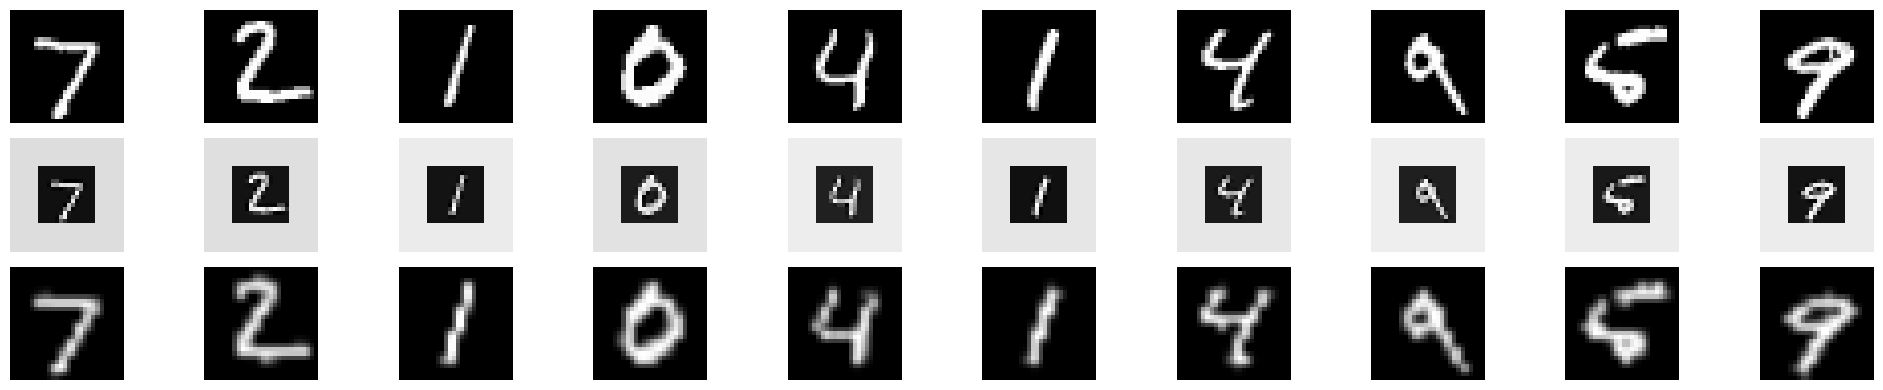

In [10]:
######################SUPER RESOLUTION WITH CCONVOLUTIONAL AUTOENCODER

class Autoencoder_Convolutional(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

        self.output_shape = output_shape

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # Resize decoded to match the output shape
        decoded = F.interpolate(decoded, size=self.output_shape[1:], mode='bilinear', align_corners=False)

        return decoded



model = Autoencoder_Convolutional((1,14,14),(1,28,28))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        reduced_resolution_images = reduce_resolution(images, scale_factor=2)  # Add noise to the images
        optimizer.zero_grad()
        outputs = model(reduced_resolution_images)
        normimg = check_normalize(images)
        loss = criterion(outputs, normimg)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}")


test_and_print(images,model,True)
